# Runtime complexity, Recursion, and estimating Feigenbaum's constant for chaos

We previously saw how to use the logistic map to model population growth. We saw that the logistic map can exhibit chaotic behavior |for certain values of the growth rate parameter $r$. we will examine more closely how the behavior of the logistic map changes as we vary the parameter $r$. We will use two different algorithms to probe the behavior of the logistic map as we vary the parameter $r$: recursion and dynamic programming.

Preamble: Run the cells below to import the necessary Python packages

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/time_and_space_complexity_recursion.ipynb)


<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

In [1]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


## Re-implementing the logistic map with classes

First we will implement two classes: One that represents the logistic map, and one that calculates its bifurcation diagram. Unlike previous lectures, we will implement the Logistic map using an iterable class. This is a standalone class `LogisticMap` that stores the value of the growth rate parameter $r$ and the current position $x$ as instance attributes. 

**Special methods in Python classes:** Python reserves certain method names for special purposes. For example, the `__init__` method is automatically called when an object is created. The `__call__` method allows an object to be treated like a function. In our implementation, we use the `__call__` method to call the internal `next` method, which implements the actual recurrence relation defined by the logistic map. We also include a `__str__` method. When we call `print(map)`, Python understands that we want to print the string returned by the `__str__` method.

In [3]:
class LogisticMap:
    """
    Implements the logistic map.

    Attributes:
        r (float): The growth rate parameter
        x (float): The current value of x for the logistic map.
    """

    def __init__(self, r=3.8, x0=0.65):
        self.r = r
        self.x = x0

    # def next(self):
    #     """Compute the next value of the map."""
    #     self.x = self.r * self.x * (1 - self.x)
    #     return self.x
    
    def simulate(self, n):
        """Simulate the map for n iterations."""
        x = []
        for _ in range(n):
            x.append(self()) # Notice that we can call the class like a function
        return x
    
    # The __call__ method allows us to call an instance of this class like a function.
    # It must return the value that should be returned when the instance is called.
    def __call__(self):
        self.x = self.r * self.x * (1 - self.x)
        return self.x
    
    # The __str__ method is called when the object is printed. It must return a string.
    def __str__(self):
        return 'Logistic map with r = {:.2f}'.format(self.r)

We can now simulate the logistic map by first initializing the class, and then calling the `simulate` method. We will simulate the map for 1000 iterations, and observe the chaotic behavior when $r$ is close to 4.

Logistic map with r = 3.80
Initial condition: 0.65
First iteration: 0.8644999999999998


Text(0, 0.5, 'x')

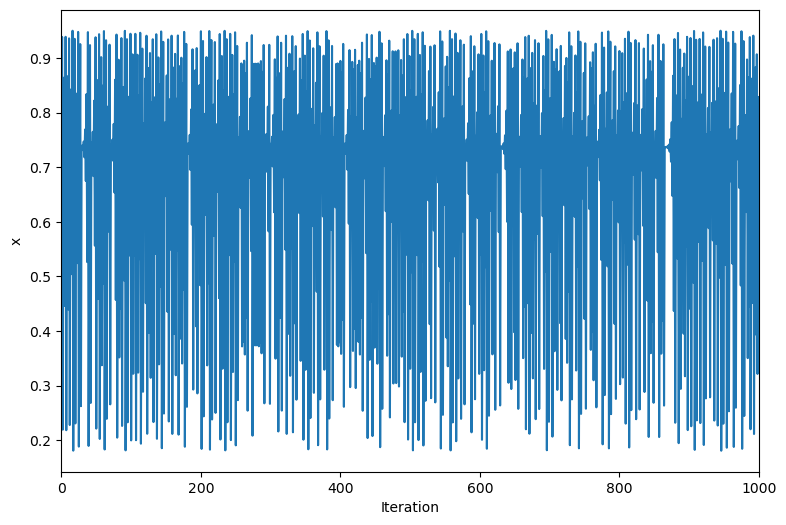

In [9]:
map = LogisticMap()

# # invoke the special __string__ method
print(map)

# # # # one step of the map
print(f"Initial condition: {map.x}")
print(f"First iteration: {map()}")


# # # plot the trajectory
traj = map.simulate(1000)
plt.figure(figsize=(9, 6))
plt.plot(traj)
plt.xlim(0, len(traj))
plt.xlabel('Iteration')
plt.ylabel('x')



Bifurcation diagrams are used to visualize the behavior of a system as a function of a parameter. In a bifurcation diagram, we we vary a control parameter (like the growth rate $r$ in the case of the logistic map) and plot the long-term behavior of the system as a function of that parameter. In the case of the logistic map, the long-term behavior of the system is given by the number of unique values of $x$ observed after the transient has elapsed.


To implement a bifurcation diagram, we will implement an **iterable** class that iterates over a range of values of the parameter $r$, and for each value of $r$, simulates the logistic map for a fixed number of iterations. We will then return the last values of the trajectory after the transient has elapsed. Python has special syntax for objects that can be used in `for` loops, or implicitly in list comprehensions. An object is iterable if it has a special method called `__iter__` that returns an object with a method called `__next__`. For our bifurcation diagram, we will use the `__iter__` method to iterate over a range of values of $r$, and the `__next__` method to simulate the logistic map for a fixed number of iterations in order to calculate the unique map values for that value of $r$.

In [11]:
   
class BifurcationDiagram:
    """
    Find the bifurcation diagram for a map using __iter__ in Python. This stateful
    implementation is more efficient than the stateless implementation we used previously,
    because it does not need to store the entire trajectory in memory.

    We will iterate over the map, one value of r at a time, and plot the last 
    values of x for each value of r after a transient has elapsed

    Attributes:
        dmap (callable): A discrete map object. Must contain a simulate method that returns a 
            trajectory of the map.
        rmin (float): The minimum value of r to use.
        rmax (float): The maximum value of r to use.
        rsteps (int): The number of steps to take between rmin and rmax.
        n (int): The number of iterations to use for each value of r.
        transient (int): The number of iterations to discard as transient.

    """

    def __init__(self, dmap, rmin, rmax, rsteps, n, transient=100):
        self.dmap = dmap
        self.rmin = rmin
        self.rmax = rmax
        self.rsteps = rsteps
        self.n = n
        self.transient = transient

    # The __iter__ method tells Python that this class is iterable. It must return an 
    # object that implements the __next__ method. Iterable objects can be used in for
    # loops and list comprehensions.
    def __iter__(self):
        return self
    
    # The __next__ method is called by the for loop to get the next item in the
    # iteration. It must return the next item, or raise StopIteration if there
    # are no more items.
    def __next__(self):
        
        # Set map to use the current value of r
        self.dmap.r = self.rmin 
        
        # Stop the calculation if we have reached the end of the parameter interval
        if self.rmin > self.rmax:
            raise StopIteration
        
        ## Otherwise, simulate the map for nsteps at the current value of r, and return
        ## the last values after the transient
        else:
            r = self.rmin
            self.rmin += self.rsteps
            return self.dmap.simulate(self.n)[self.transient:], r
        


Now that we have a working implementation of the logistic map, we can use it to explore the relationship between the growth rate $r$ and the long-term behavior of the system. We will use the `BifurcationDiagram` class to generate a bifurcation diagram for the logistic map. We will first instantiate a specific instance of the `LogisticMap` class, and then pass it to a specific instance of the `BifurcationDiagram` class stored in the variable `diagram`.

However, we don't actually perform any calculations yet. We need to iterate over the `diagram` object to perform the calculations. We can do this using a `for` loop. At each call to the for loop, the `__next__` method of the `diagram` object is called, which simulates the map for a fixed number of iterations at the current value of $r$, and returns the last values of the trajectory after the transient has elapsed, as well as the current value of $r$. We then immediately unpack the tuple returned by `__next__` into the variables `traj` and `r`, and plot the trajectory against $r$.

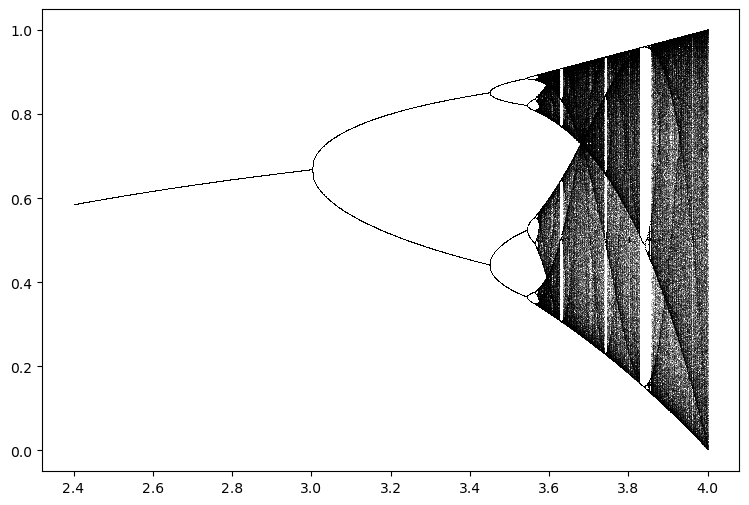

In [14]:
## Instantiate a bifurcation diagram for the logistic map
diagram = BifurcationDiagram(LogisticMap(), 2.4, 4.0, 0.001, 1000)

plt.figure(figsize=(9, 6))

# ## We can iterate over the diagram object itself to get the values of r and x
for traj, r in diagram:
    plt.plot([r] * len(traj), traj, ',k', alpha=0.25)

# plt.xlabel('r')
# plt.ylabel('x')
# plt.xlim(2.4, 4.0)

**Lazy evaluation** is a programming concept that means that a function or expression is not evaluated until its value is needed. In Python, lazy evaluation can be used to avoid unnecessary computation or memory allocation. In some database scenarios, lazy evaluation can be used to avoid reading data from disk until it is needed. Python has a built-in lazy evaluation mechanism called **generators**, but above we have implemented our own custom iterable class to illustrate the concept.

<br>
<br>


## How often does the logistic map undergo period doubling?

When does the logistic map undergo period doubling? On the bifurcation diagram, we see that the period doubles at certain values of $r$. Initially, these values are spaced pretty far apart in $r$, but as we move to the right on the bifurcation diagram, the values of $r$ at which the period doubles appear to get closer and closer together. Is there any interesting structure in the spacing of these values of $r$?

We want to find these exact values of $r$ at which the period doubles. In the following sections, we will use a variety of search algorithms to localize the values of $r$ at which the period doubles.

Our code will consist of two parts: 

1. A "check" function that compares trajectories at two different values of $r$, and then determines whether the period of the logistic map doubled between them. This will take two trajectories corresponding to two different values of $r$, and then estimate the number of unique values in the two trajectories. If the number of unique values is twice as large for the second trajectory as the first, we will return `True`, indicating that the period has doubled. This function will thus return a boolean value.

2. A "search" function that uses the "check" function to find the values of $r$ at which the period doubles. This function will return a list of values of $r$ at which the period doubles.

We will start by implementing the "check" function. Because we are working with a discrete map, we can simply compare the last few values of the two trajectories to determine whether the period has doubled. However, because we are working with floating point numbers, we need to be careful about the precision of the comparison. We thus implement a rounding function that truncates the trajectory to a certain number of decimal places.

In [19]:
def check_period_doubling(prev_traj, current_traj, tolerance=0.3):
    """
    Check if the period has doubled from the previous trajectory to the current 
    trajectory. Uses a basic test of whether the number of unique values in the
    current trajectory is greater than the number of unique values in the previous
    trajectory.
    
    Args:
        prev_traj (array): Previous trajectory
        current_traj (array): Current trajectory
        tolerance (float): How close the period doubling ratio must be to 2 in order to
            be considered a period doubling event.

    Returns:
        bool: True if period doubled, False otherwise
    """
    
    # Round each trajectory to 4 decimal places to avoid numerical errors, and then
    # count the number of unique values seen. A period 2 orbit will have 2 unique
    # values, a period 4 orbit will have 4 unique values, and so on.
    prev_unique_vals = len(np.unique(np.round(prev_traj, decimals=4)))
    current_unique_vals = len(set(np.round(current_traj, decimals=4)))
    
    # Check to see if the number of unique values has doubled, to within a threshold
    has_doubled = np.abs(current_unique_vals / prev_unique_vals - 2) < tolerance
    # has_doubled = (current_unique_vals == 2 * prev_unique_vals)
    return has_doubled

### Line scanning

Our first search algorithm will be a simple "line scan" through the parameter space. We will take a range of evenly-spaced $r$ values between $r_{\text{min}}$ and $r_{\text{max}}$, and for each value of $r$, we will simulate the map for a fixed number of iterations. We will then check whether the period has doubled from the previous value of $r$ to the current value of $r$. The cost of this search algorithm is $\mathcal{O}(N)$ where $N$ is the number of $r$ values we scan over. As its name implies, this algorithm thus has $\mathcal{O}(N)$ complexity, meaning that its runtime grows linearly with the number of decimal places we need to represent the $r$ values.

In [20]:
def line_scan(dmap, rmin, rmax, n_rvals=100, transient=50):
    """
    Find the doubling points for a map using a line scan
   
    Scan the values of r between rmin and rmax and find the values of r where the
    map doubles in period. This function uses the discrete map's simulate method
    to generate a trajectory for each value of r.

    Args:
        dmap (object): A discrete map object. Must contain a simulate method that
            returns a trajectory of the map.
        rmin (float): The minimum value of r to use.
        rmax (float): The maximum value of r to use.
        n_rvals (int): The number of values of r to use between rmin and rmax.
        transient (int): The number of iterations to discard as transient.

    Returns:
        array: An array of values of r where the map doubles in period.
    
    """
    ## Create an array of r values to scan over
    rvals = np.linspace(rmin, rmax, n_rvals)
    doubling_rvals = []
    prev_traj = None
    for r in rvals:

        ## Set the parameter value and simulate the map in order to get a trajectory
        dmap.r = r
        traj = np.array(dmap.simulate(1000)[-transient:])
        
        # If we have a previous trajectory, check for period doubling. If it 
        # has doubled, add the current value of r to the list of doubling r values
        if prev_traj is not None:
            if check_period_doubling(prev_traj, traj):
                doubling_rvals.append(r)

        ## Update the previous trajectory
        prev_traj = traj

    return np.array(doubling_rvals)


import time
start = time.time()
rvals_c = line_scan(LogisticMap(), 2.4, 3.57, n_rvals=300)
print(rvals_c)
end = time.time()
print(f"Time elapsed: {end - start} seconds")

# # filter out values that change by less than 0.01
# rvals_c = rvals_c[:-1][np.diff(rvals_c) > (3.6 - 2.4) / (1000 - 1)]

# plt.figure()
# gaps = rvals_c[1:] - rvals_c[:-1]
# plt.plot(gaps)
# print(gaps[:-1] / gaps[1:])

# vals = [3.0]
# gap = 0.45252525
# for i in range(5):
#     nxt = vals[-1] + gap
#     vals.append(nxt)
#     gap = gap / 4.667
# rvals_c = np.array(vals)
# gaps = rvals_c[1:] - rvals_c[:-1]
# plt.plot(gaps)

[2.99869565 3.44869565 3.54652174 3.56608696]
Time elapsed: 0.04610419273376465 seconds


Now that we've found the period doubling values of $r$, we can plot these values on top of the bifurcation diagram, to see whether they look right.

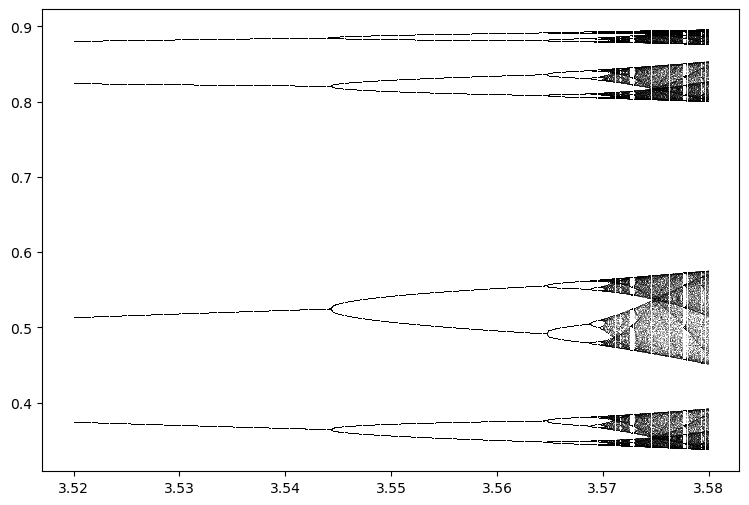

In [56]:
plt.figure(figsize=(9, 6))

## Create and plot the bifurcation diagram
diagram = BifurcationDiagram(LogisticMap(), 3.52, 3.58, 0.0001, 1000)
for traj, r in diagram:
    plt.plot([r] * len(traj), traj, ',k', alpha=0.25)

(2.8, 3.6)

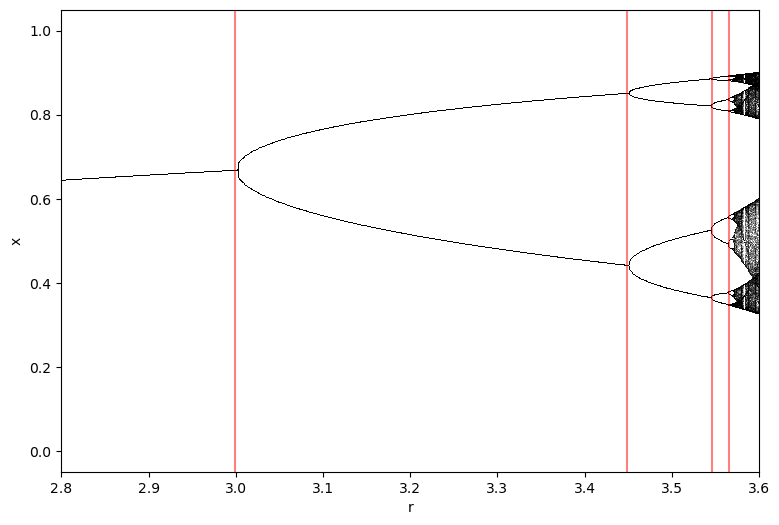

In [21]:
plt.figure(figsize=(9, 6))

## Create and plot the bifurcation diagram
diagram = BifurcationDiagram(LogisticMap(),  2.4, 4.0, 0.001, 1000)
for traj, r in diagram:
    plt.plot([r] * len(traj), traj, ',k', alpha=0.25)

## Draw vertical lines at the period doubling points we found
for r in rvals_c:
    plt.axvline(r, color='r', alpha=0.5)

plt.xlabel('r')
plt.ylabel('x')
# plt.xlim(2.4, 3.6)
plt.xlim(2.8, 3.6)

How are these doubling events distributed? We will plot the gaps (in $r$) between successive doubling events to see if they follow a pattern.

Ratios between successive doublings: [4.6 5. ]


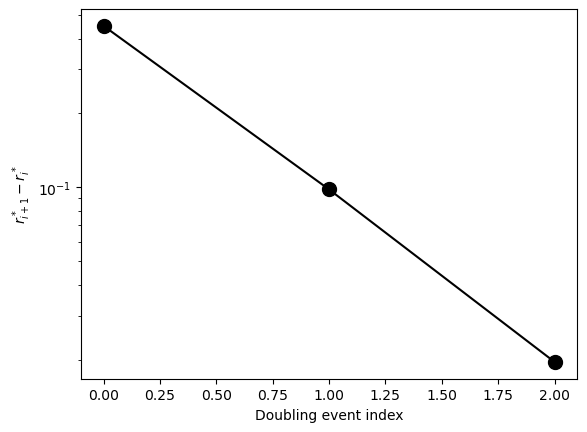

In [22]:
# filter out values that change by less than 0.01
# rvals_c = rvals_c[:-1][np.diff(rvals_c) > (3.6 - 2.4) / (10000 - 1)]

plt.figure()
gaps = rvals_c[1:] - rvals_c[:-1]
plt.xlabel('Doubling event index')
# in latex r_c
plt.ylabel('$r^*_{i+1} - r^*_i$')


plt.semilogy(gaps, '.k', markersize=20)
plt.semilogy(gaps, '-k')
print(f"Ratios between successive doublings: {gaps[:-1] / gaps[1:]}")


We can see that the spacing between successive doublings is decreasing as a power series, which roughly matches what we can see on the bifurcation diagram. However, we can see from looking at the bifurcation diagram that the localizations are not extremely accurate. Because a line scan densely samples the parameter space, the expected precision of the line scan is about $1/N$, where $N$ is the number of $r$ values we scan over. So for the 1000 points we used here, we can expect about 3 decimal places of accuracy. We could thus say that a line scan has $\mathcal{O}(N)$ scaling of precision.

<br>
<br>
<br>


## Binary search

A binary search is a search algorithm that works on a sorted list or array. Rather than checking each element in the list, binary search exploits the sorted structure to ignore large parts of the list in each iteration. At each iteration, we check the middle element of the list, and then recursively search *only* the left or right half of the list, depending on whether the doubling event occurs in that half.

Binary search has runtime cost $\mathcal{O}\left(\log{(N)}\right)$ because it cuts the list in half each time. It thus gains a digit of precision in the search for each iteration.

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/binary_search.png" style="max-width:60%; height:auto;">

To implement a standard binary search on a sorted array, we use a **two-pointer** approach. We initialize two variables (pointers) corresponding to the index of the first and last elements of the array. At each iteration, we use the two pointers to find the middle index of the array. If the value at the middle index is greater than the target, we move the right pointer to the middle index. Otherwise, we move the left pointer to the middle index. We repeat this process until the left and right pointers meet. The index of the left pointer is the index of the first element greater than or equal to the target.

In [31]:
def binary_search(a, target):
    """
    Find the index of the first element in a *sorted* array that is greater than or 
    equal to the target.

    We are using a two-pointer approach where one pointer is always greater than the 
    target and the other is always less than the target. The pointers start at the ends 
    of the array and move towards each other until they meet. The index of the left 
    pointer is the index of the first element greater than or equal to the target.

    Args:
        a (array): A sorted array of numbers.
        target (float): The target value to search for.

    Returns:
        int: The index of the first element greater than or equal to target.
    """
    lo = 0
    hi = len(a)
    while lo < hi:
        mid = (lo + hi) // 2
        if a[mid] < target:
            lo = mid + 1
        else:
            hi = mid
    return lo

a = np.array([1, 2, 3, 4, 7, 8, 9, 10, 15, 43, 99])

print(binary_search(a, 5))

4


# Determining Big-O for an algorithm

Big-O notation is a way to describe the runtime and memory complexity of an algorithm. It describes how the runtime of an algorithm scales with the size $N$ of the input. For example, if an algorithm takes 1000 time steps to run on a problem of size $N=100$, then a linear scaling algorithm ($\mathcal{O}(N)$) will take 2000 time steps to run on a problem of size $N=200$. A quadratic scaling algorithm ($\mathcal{O}(N^2)$) will take 40000 time steps to run on a problem of size $N=200$.

Usually, when estimating the "Big-O" of an algorithm, we are interested in the *worst-case* runtime. This is the maximum amount of time the algorithm will take to run on any input of size $N$. However, there is often an ambiguity regarding the definition of $N$. It can be the total number of particles, total number of mesh points, total number of time steps. It usually corresponds to an extensive quantity or resolution parameter.

In practice, the Big-O scaling of an algorithm is almost always some combination of a polynomial $N^{\alpha}$ and $\log(N)$. However, certain minimal operations, such as overwriting values, peeking the front of a queue, etc take constant time ($\mathcal{O}(1)$).

There are some useful Big-O times to know:
+ Logarithmic scaling ($\log{(N)}$) usually means you can quickly rule out large parts the problem without directly looking at the associated values. This case arises in algorithms like recursion, bisection search, etc.
+ Exponential scaling ($\text{exp}\left(N\right)$) implies a combinatoric explosion as the number of inputs increases, such as a process that branches. This is usually not optimal, but some problems are inherently exponential. An example is the traveling salesman problem, or finding the global ground state of a set of $N$ randomly-coupled Ising spins.
+ Stirling's approximation: $N! \sim \sqrt{N} e^{-N} N^N$ or $\log{(N!)} \sim N \log{(N)}$
+ Sorting a list via mergesort is $\mathcal{O}(N \log(N))$ 
+ Binary search, two-sum are pointers with $\log{(N)}$ time
+ Dot product of two length-$N$ vectors is $\mathcal{O}(N)$. $N \times N$ matrix-vector product is $\mathcal{O}(N^2)$. Product of two $N \times N$ matrices is $\mathcal{O}(N^3)$

Text(0, 0.5, 'Time (s)')

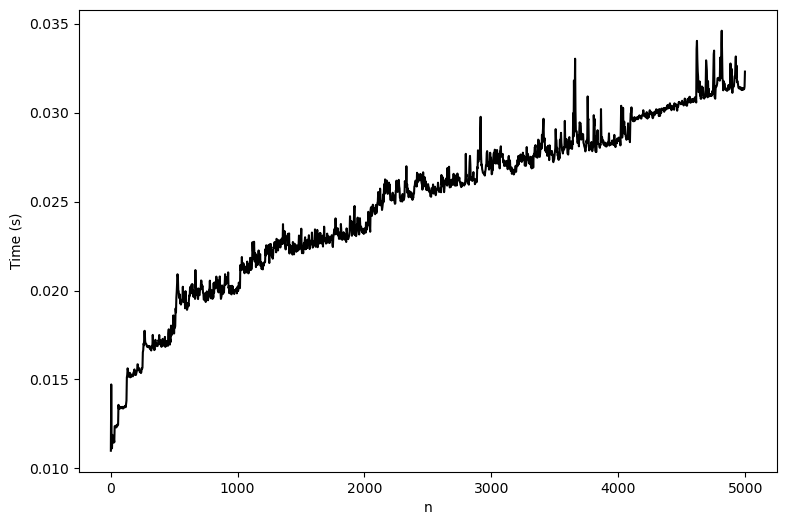

In [372]:
import timeit 
nvals = np.arange(2, 800)

nvals = np.arange(2, 5000, 3)
all_times = list()
for n in nvals:
    all_reps = list()
    all_times.append(
        timeit.timeit(
            "binary_search(np.arange(n), n // 2)", globals=globals(), number=10000
        )
    )

plt.figure(figsize=(9, 6))
plt.plot(nvals, all_times, 'k')
plt.xlabel('n')
plt.ylabel('Time (s)')

We can see that the runtime of binary search is $\mathcal{O}\left(\log{(N)}\right)$. This is because the algorithm cuts the size of the list in half each time. Since the list is already sorted, we are able to quickly rule out half of the input each time we make a comparison, thus sparing us the $\mathcal{O}(N)$ cost of checking each element in the list, unlike the linear scan.

<br>
<br>
<br>
<br>
<br>

# Calculation periodic doubling values in the logistic map with binary search

Now let's return to our logistic map example. We will use a binary search to find the values of $r$ at which the period doubles. Because binary search avoids scanning many parameter values, we can avoid many intermediate values of $r$ between the doubling events.


### Implementing binary search for period doubling

There a are a few nuances to our approach, compared to traditional binary search.

1. We need to perform a **three-pointer comparison** among the periods of the logistic map at $r_{min}$, $r_{middle}$, and $r_{max}$. This is because we are searching on a continuous parameter space. We thus implement a three-way comparison function, which requires three trajectories at three different values of $r$ to be passed in, and identifies if the period doubles between the first and second trajectories, or the second and third trajectories.

2. We need to find *all* values of $r$ corresponding to critical doubling values, rather than just one value. This requires multiple binary searches over different intervals, as well as a heuristic for modifying the intervals to ensure that we don't repeatedly find the same root. We break down this process as follows:

    a. We start by searching the full $r$ interval for the first doubling value.
    
    b. Upon finding a doubling value, we shrink the interval so that the rightmost pointer is just below the root we just found by some tolerance $\epsilon$. 
    
    c. We search the new interval for the next doubling value, and repeat the process.
    
This heuristic will fail if the period doubling values are closer than $\epsilon$ apart. In this case, we would need to reduce $\epsilon$ and try again. This same difficulty arises in methods used to find multiple roots (zero crossings) of continuous functions.

Ratios between successive doublings: [4.67187821 4.69514424 0.57676821]


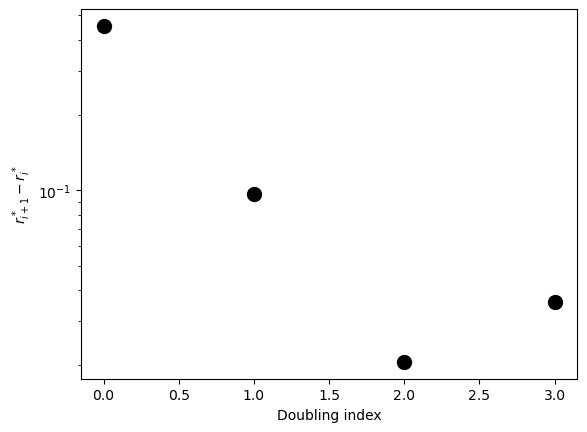

In [75]:

## Three-way comparison function
def check_period_doubling2(left_traj, middle_traj, right_traj):
    """
    Check if the period doubles between right_traj and middle_traj
    
    Functions by testing whether the number of unique values in the current trajectory 
    is greater than the number of unique values in the previous trajectory.
    
    Args:
        prev_traj (array): Previous trajectory
        current_traj (array): Current trajectory
        threshold (float): A threshold value to determine the similarity between points

    Returns:
        bool: True if period doubled, False otherwise
    """
    
    ## For each trajectory, count the number of unique values, to see what the period is
    t_left = len(set(np.round(left_traj, decimals=4)))
    t_middle = len(set(np.round(middle_traj, decimals=4)))
    t_right = len(set(np.round(right_traj, decimals=4)))
    
    ## Check to see if the period has doubled by comparing the ratios of the number of
    ## unique values in the trajectories
    factor_right = t_middle / t_left
    factor_left = t_right / t_middle

    return factor_right > factor_left

def binary_search_between(dmap, rmin, rmax, transient=50, tol=1e-6):
    """
    Find a doubling between rmin and rmax using a binary search

    Scan the values of r between rmin and rmax and find the values of r where the
    map doubles in period. This function uses the discrete map's simulate method
    to generate a trajectory for each value of r.

    Args:
        dmap (object): A discrete map object. Must contain a simulate method that
            returns a trajectory of the map.
        rmin (float): The minimum value of r to use.
        rmax (float): The maximum value of r to use.
        transient (int): The number of iterations to discard as transient.
        tol (float): The tolerance for the binary search.

    Returns:
        float: The value of r where the map doubles in period.
    """
    # print(f"Searching between {rmin} and {rmax}")

    while rmax - rmin > tol:
        rmid = (rmax + rmin) / 2

        ## Simulate the logistic map at the minimum, middle, and maximum values of r
        dmap.__init__(r=rmin)
        traj_min = np.array(dmap.simulate(1000)[-transient:])
        dmap.__init__(r=rmid)
        traj_mid = np.array(dmap.simulate(1000)[-transient:])
        dmap.__init__(r=rmax)
        traj_max = np.array(dmap.simulate(1000)[-transient:])

        ## If the period has doubled between the middle and maximum values of r, set
        ## rmin to rmid. Otherwise, set rmin to rmid.
        where_double = check_period_doubling2(traj_min, traj_mid, traj_max)
        if where_double:
            rmax = rmid
        else:
            rmin = rmid
    return rmid


def binary_search_bifurcation(dmap, rmin, rmax, n_iter, transient=50):
    """
    Find doublings using a multipointer binary search

    Scan the values of r between rmin and rmax and find the values of r where the
    map doubles in period. This function uses the discrete map's simulate method
    to generate a trajectory for each value of r.

    Args:
        dmap (object): A discrete map object. Must contain a simulate method that
            returns a trajectory of the map.
        rmin (float): The minimum value of r to use.
        rmax (float): The maximum value of r to use.
        n_iter (int): The number of iterations to use for each value of r.
        transient (int): The number of iterations to discard as transient.

    Returns:
        array: An array of values of r where the map period doubles
    """
    rvals = []
    # narrow down the search between every pair of successive pointers to find a doubling
    for i in range(n_iter):
        rmax_new = binary_search_between(dmap, rmin, rmax, transient=transient)
        if np.abs(rmax - rmax_new) < 1e-3:
            rmax -= 1e-4
        else:
            rvals.append(rmax)
            rmax = rmax_new
    return np.array(rvals)[::-1]

rvals_c = binary_search_bifurcation(LogisticMap(), 2.8, 3.6, 10, transient=50)

plt.figure()
gaps = rvals_c[1:] - rvals_c[:-1]
plt.xlabel('Doubling index')
plt.ylabel('$r^*_{i+1} - r^*_i$')

plt.semilogy(gaps, '.k', markersize=20)
print(f"Ratios between successive doublings: {gaps[:-1] / gaps[1:]}")


In [ ]:
rvals_c = np.array([
    binary_search_between(LogisticMap(), 2.9, 3.1, 20, tol=1e-8,),
    binary_search_between(LogisticMap(), 3.1, 3.54, 20, tol=1e-8),
    binary_search_between(LogisticMap(), 3.54, 3.56, 20, tol=1e-8),
    binary_search_between(LogisticMap(), 3.56, 3.57, 20, tol=1e-8),
])

plt.figure()
gaps = rvals_c[1:] - rvals_c[:-1]
plt.xlabel('Doubling index')
plt.ylabel('$r^*_{i+1} - r^*_i$')

plt.semilogy(gaps, '.k', markersize=20)
print(f"Ratios between successive doublings: {gaps[:-1] / gaps[1:]}")

TypeError: binary_search_between() got multiple values for argument 'transient'

(2.8, 3.6)

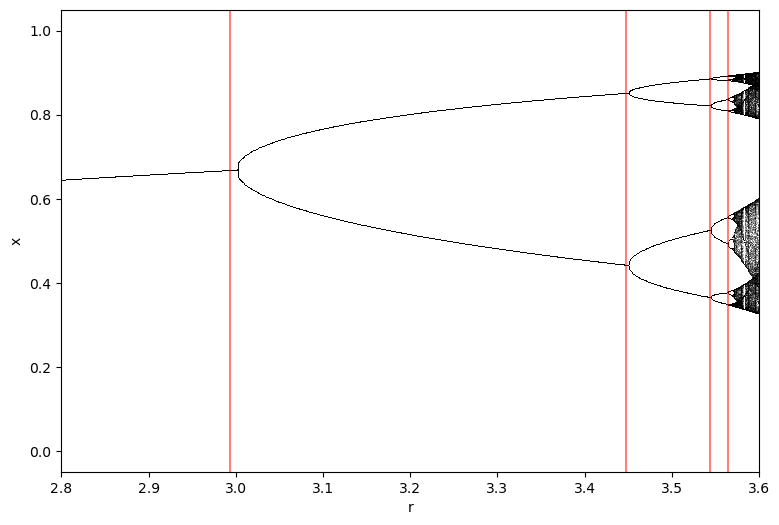

In [82]:
plt.figure(figsize=(9, 6))

## Create and plot the bifurcation diagram
diagram = BifurcationDiagram(LogisticMap(), 2.4, 4.0, 0.001, 1000)
for traj, r in diagram:
    plt.plot([r] * len(traj), traj, ',k', alpha=0.25)

## Draw vertical lines at the period doubling points we found
for r in rvals_c:
    plt.axvline(r, color='r', alpha=0.5)

plt.xlabel('r')
plt.ylabel('x')
# plt.xlim(2.4, 3.6)
plt.xlim(2.8, 3.6)

## What's going on physically?

Many chaotic systems approach chaos through a series of bifurcations, which occur at spacings on the bifurcation diagram equal to [Feigenbaum's constant](https://doi.org/10.1007/BF01020332). If $r$ is the parameter of the logistic map, and $r^*_i$ and $r^*_{i+1}$ are the critical parameter values of successive doubling bifurcations, then the ratio of successive bifurcation intervals approaches Feigenbaum's constant:

$$\lim_{i \rightarrow \infty} \frac{r^*_{i+1} - r^*_i}{r^*_{i+2} - r^*_{i+1}} = \delta \approx 4.66920\ldots$$

The gap between successive doublings therefore decreases as a geometric series, with a ratio of $\delta$. A geometric series decreasing by $\delta$ converges to a finite value, which here corresponds to the onset of chaos at $r \approx 3.56995$ in the logistic map.

The Feigenbaum constant is a universal constant, meaning that it is the same for all systems that exhibit period-doubling bifurcations. It was first measured in an experimental system by [Libchaber & Maurer in 1986](http://dx.doi.org/10.1051/jphyscol:1980309), who studied the period-doubling cascade in a Rayleigh-Bénard convection cell. This system consists of a thin layer of fluid heated from below, with convection rolls forming once the Rayleigh number exceeds a critical threshold. By carefully controlling the heating, they observed the onset of oscillatory instabilities, followed by a cascade of period-doubling bifurcations, eventually leading to turbulence.

<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Recursion and dynamic programming

For some problms, the solution to a size $N$ input can be written in terms of the previous $N - 1$, $N - 2$, etc. inputs. For example, the Fibonacci sequence: $F_N = F_{N - 1} + F_{N - 2}$, with $F_0 = 0$, $F_1 = 1$. Problems of this form can be solved with recursion, which is a way of breaking a problem down into smaller and smaller pieces until you reach a limiting case



<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/recursion.png" style="max-width:40%; height:auto;">

There are two key components to finding a recursive solution to a problem of size $N$:

1. Inductive reasoning: We find a way to write any case for $N$ in terms of $N - 1$, $N - 2$, etc
2. Base cases: the limit of the problem when $N$ is small. For example, $0! = 1$, $x_0 = 1$ (initial conditions), etc


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


### Computing the factorial function

We will next implement two different approaches to computing the factorial function: *recursion* and *dynamic programming*.

Problem: Find $N!$
+ Inductive reasoning: $N! = N \times (N - 1)!$
+ Base case: $0! = 1$



In [27]:
def factorial(n):
    """Compute n factorial via recursion"""
    # print(n, flush=True)
    
    # Base case
    if n == 0:
        return 1
    
    # Recursive case in which the function calls itself
    else:
        return n * factorial(n - 1) #+ factorial(n - 2)
    
factorial(3)

6

We can estimate the runtime scaling of this function using the `timeit` utility.

Text(0, 0.5, 'Time (s)')

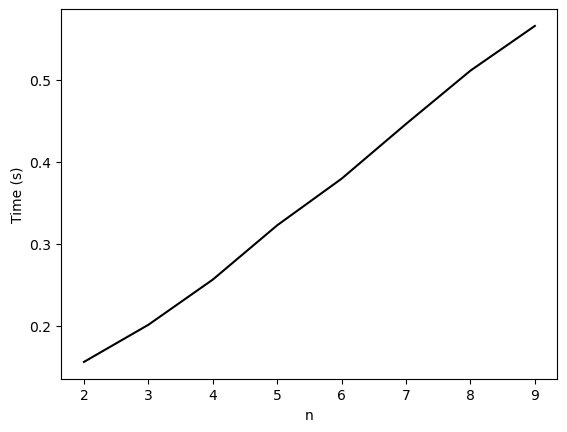

In [41]:

### Run a timing test
import timeit
nvals = np.arange(2, 10)
all_times = list()
for n in nvals:
    all_times.append(
        timeit.timeit("factorial(n)", globals=globals(), number=1000000)
    )

plt.figure()
plt.plot(nvals, all_times, 'k')
plt.xlabel('n')
plt.ylabel('Time (s)')


Instead of recursion, we can instead consider a bottom-up approach to the problem, which starts from the base case and builds up to the desired solution. This is called *dynamic programming*.

+ Problem: Find $N!$
+ Inductive reasoning: $N! = N \times (N - 1)!$
+ Base case: $0! = 1$

In [ ]:
def factorial(n):
    """Compute n factorial, for n >= 0, with dynamic programming."""
    
    # Start with base case
    if n == 0:
        return 1
    
    nprev = 1
    for i in range(1, n + 1):
        # print(nprev, flush=True)
        nprev *= i
        # nprev = nprev * i
    return nprev

factorial(4)

6

Text(0, 0.5, 'Time (s)')

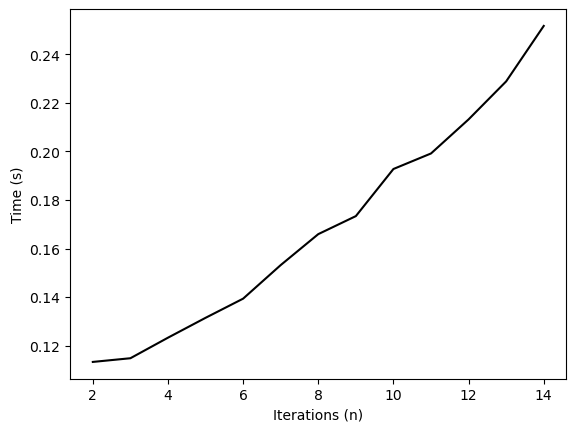

In [43]:
def factorial(n):
    """Compute n factorial, for n >= 0, with dynamic programming."""
    
    # Start with base case
    if n in [0, 1]:
        return 1
    
    nprev = 1
    for i in range(2, n + 1):
        nprev *= i
        # nprev = nprev * i
    return nprev


import timeit
nvals = np.arange(2, 15)
all_times = list()
for n in nvals:
    all_times.append(
        timeit.timeit("factorial(n)", globals=globals(), number=1000000)
    )

plt.figure()
plt.plot(nvals, all_times, 'k')
plt.xlabel('Iterations (n)')
plt.ylabel('Time (s)')





### Recursion vs Dynamic programming


Both recursion and dynamic programming use a "divide and conquer" approach, but they work in opposite directions. In recursion, we start from $N$ and work our way down to a base case. In dynamic programming, we start from the base case and work our way up to $N$.
 
When working with graphs or trees, we often encounter recursion due to the need to perform depth-first search starting from a given node and continuing until a base case (like a leaf node) is reached. Conversely, in time-ordered processes, we often encounter dynamic programming due to the need to build up a solution from a base case (the initial conditions).

Dynamic programming is typically $\mathcal{O}(N)$ runtime, $\mathcal{O}(1)$ memory. Recursion is ideally $\mathcal{O}(Log(N))$ runtime, but for exhaustive searches it can be $\mathcal{O}(N)$ runtime, $\mathcal{O}(N)$ memory because we can't skip any steps

<br>
<br>
<br>
<br>


## A subtlety of timing algorithms

Why did we only run timing tests of our factorial function for inputs up to $N = 50$? What complicates our analysis if we try timing larger values of $N$?

Text(0, 0.5, 'Time (s)')

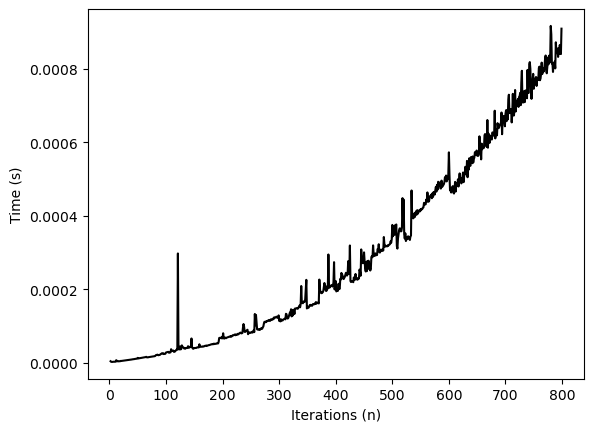

In [44]:
import timeit
nvals = np.arange(2, 800)
all_times = list()
for n in nvals:
    all_times.append(
        timeit.timeit("factorial(n)", globals=globals(), number=10)
    )

plt.figure()
plt.plot(nvals, all_times, 'k')
plt.xlabel('Iterations (n)')
plt.ylabel('Time (s)')

We naively expect that the runtime of our factorial function should scale linearly with $N$. However, it turns out that multiplying large floats has unfavorable scaling with $N$. Gradeschool multiplication is $O(N^2)$ where $N$ is the number of digits, and Karatsuba multiplication is $O(N^{1.585})$.

<br>
<br>
<br>
<br>


## More recursion practice: The Fibonacci sequence

We next apply this approach to computing the Fibonacci sequence, which is famously defined by the recurrence relation

$$\text{Fib}(N) = \text{Fib}(N - 1) + \text{Fib}(N - 2)$$

The first few Fibonacci numbers are $1, 1, 2, 3, 5, 8, 13, 21, 34, 55, \ldots$

We can start by writing a recursive function to compute the Fibonacci sequence. The base cases are $\text{Fib}(0) = 0$ and $\text{Fib}(1) = 1$.

Text(0, 0.5, 'Time (s)')

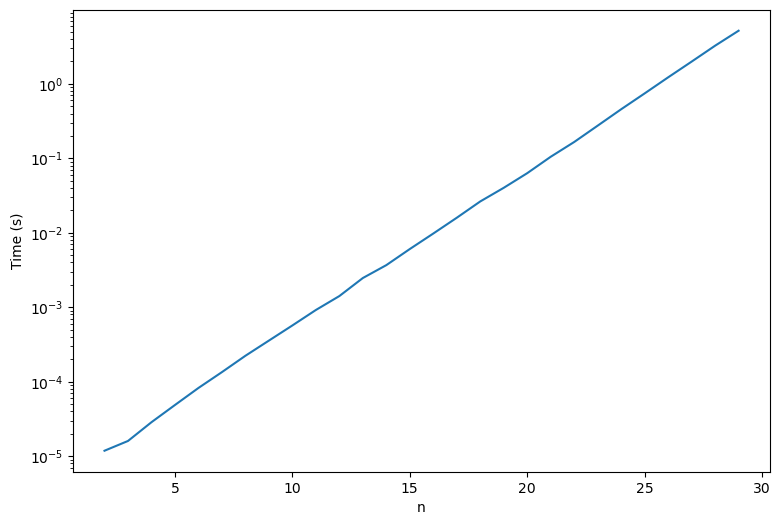

In [441]:
def fibonacci(n):
    """Compute the nth Fibonacci number via recursion"""
    # Base cases
    if n == 0:
        return 0
    elif n == 1:
        return 1

    # Recursive case
    else:
        return fibonacci(n - 1) + fibonacci(n - 2)

nvals = np.arange(2, 30)
all_times = list()
for n in nvals:
    all_times.append(
        timeit.timeit("fibonacci(n)", globals=globals(), number=10)
    )

plt.figure(figsize=(9, 6))
plt.semilogy(nvals, all_times)
plt.xlabel("n")
plt.ylabel("Time (s)")


As before, the dynamic programming starts with the base cases and builds up to the solution.

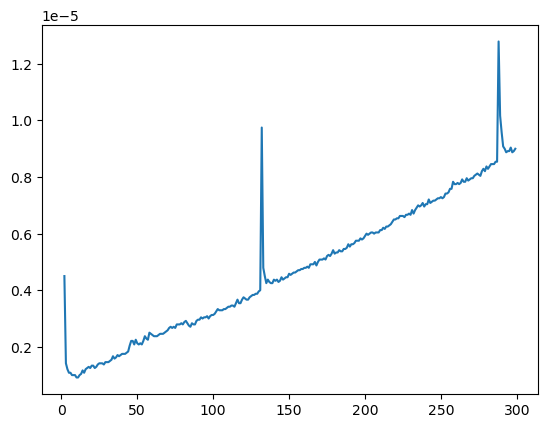

In [427]:
def fibonacci(n):
    """Compute the nth Fibonacci number via dynamic programming."""
    
    if n == 0:
        return 0
    elif n == 1:
        return 1

    n1, n2 = 0, 1
    for i in range(2, n + 1):
        n1, n2 = n2, n1 + n2
    return n2


nvals = np.arange(2, 300)
all_times = list()
for n in nvals:
    all_times.append(
        timeit.timeit("fibonacci(n)", globals=globals(), number=1)
    )
plt.plot(nvals, all_times)


## Questions

+ Unlike the factorial function, the recursive approach is much slower than the dynamic programming approach, even though they both have the same asymptotic complexity. Why is this?

<br>
<br>
<br>
<br>
<br>


## Recursion versus dynamic programming as discrete-time dynamical systems

We can also think of recursion and dynamic programming as dynamical systems. In this case, the input $N$ is the time variable, and the output is the state of the system at time $N$.

For example, the factorial function can be written as the dynamical system

$$x_{N} = x_{N - 1} \cdot N$$

with initial condition $x_0 = 1$.

The Fibonacci sequence can be written as the dynamical system

$$x_{N} = x_{N - 1} + x_{N - 2}$$

with initial conditions $x_0 = 1$ and $x_1 = 1$.

Dynamic programming corresponds to simulating the dynamical system forward in time, starting from the initial condition. Recursion corresponds to simulating the dynamical system backward in time, starting from the final condition.

<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Recursion and dynamic programming: Depth-first search versus breadth-first search

Generally, recursion vs dynamic programming consists of two different "schema" for solving problems. In dynamic programming, we start from the base case and work our way up to the solution. In recursion, we start from the big $N$ case and then work our way down to the base case.

In both cases, the worst-case complexity is $\mathcal{O}(N_v + N_e)$, where $N_v$, $N_e$ are the number of vertices and edges, respectively. The number of edges of a hypercube is $N_e = d N_v / 2$, where $d$ is the dimension. This implies a worst-case $\mathcal{O}(N)$ complexity for both dfs and bfs in a square lattice with $N$ vertices.

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/bfs.gif" style="max-width:70%; height:auto;">>

*Source: https://www.geeksforgeeks.org/program-for-nth-fibonacci-number/*

<img src="https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/dfs.gif" style="max-width:70%; height:auto;">>

*Source: https://www.geeksforgeeks.org/program-for-nth-fibonacci-number/*

#### Looking ahead to Homework 1: The Abelian sandpile

You can implement toppling as either BFS or DFS, or using a purely iterative approach. Physically, what do these different scenarios represent?

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## The Partition function of the 1D Ising model

The one-dimensional nearest-neighbor Ising model is a simple model of a magnetized material. The energy of the system is given by

$$
    \mathcal{H} = -J \sum_{i=1}^{N} \sigma_i \sigma_{i+1} - h \sum_{i=1}^{N} \sigma_i
$$

where $\sigma_i = \pm 1$ is the spin of the $i$th particle, and $J$ is the interaction strength, and $h$ is an external magnetic field that biases the spins.

The partition function of the system is given by

$$
    Z = \sum_{\{\sigma_i\}} e^{-\beta \mathcal{H}}
$$

where $\beta = 1/T$ is the inverse temperature. Computing the sum in the partition function is a classic example of a recursive problem. Setting $\beta=1$ without loss of generality (it can be absorbed into $J$ and $h$), we can write the partition function as

$$
    Z = \sum_{\{\sigma_i\}} e^{-\mathcal{H}}
$$

How can we compute this sum efficiently? We can use a recursive approach to compute the sum.



